In [1]:
import pandas as pd
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Permuted Data")
df

In [6]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=20488):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [7]:
smiles = df['Standardized_SMILES'].values

In [8]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [9]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
0,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(-c2cscn2...,5.36,405.527,4.36920,0.472923,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CCNC(=O)c1ccc(-c2ccc3c(c2)CCN(CCN2CCCC2)C3=O)cc1,4.80,391.515,3.19740,0.822795,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CNC(=O)c1ccc(CC(=O)N(C)C2CCN(Cc3ccc(C(F)(F)F)c...,5.68,447.501,3.73050,0.734380,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C1=NCCC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCO...,5.12,399.498,4.94840,0.511598,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,N=c1nc(N2CCC(N(CCc3ccc(Cl)cc3)CC3CCCO3)CC2)[nH...,4.82,404.946,2.56317,0.661769,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
1257,CCC(CC)CN=c1c(C(N)=O)c[nH]c2ccc(-c3cncnc3)cc12,6.12,349.438,3.06070,0.715455,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1258,CCC(NC(=O)c1ccc(Cl)cc1)C1C2CC(n3cnc4c(F)cc(F)c...,5.72,429.898,5.37360,0.591999,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1259,Cc1ncccc1-c1nc2cn(-c3cccc(OC(F)F)c3)nc2c(=O)n1...,5.08,550.610,4.44502,0.320523,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1260,CC(C)OCC(Oc1ncnc2c1cnn2-c1ncccc1Cl)C(=O)N=c1cc...,4.20,488.335,3.14530,0.424432,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
#Now incorporate this sort of noise into df during the training

In [11]:
X.shape

(1262, 20488)

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_fcv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]

    rmse=list()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        model = nn.MLPRegressor(hidden_layer_sizes=(min(25,round(np.sqrt(X_train.shape[0])),)), random_state=42)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    # Optionally, save the results to a DataFrame
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        'Sort By': sort_by_all
    })

    # Saving to CSV (optional)
    results_df.to_csv("unsorted_fcv_results_MLP.csv", index=False)

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.403537642177656, pvalue=2.794415406376801e-06)
PearsonRResult(statistic=0.6152165044208591, pvalue=1.7929225380721902e-14)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.5684693995299221, pvalue=3.827673696731106e-12)
PearsonRResult(statistic=0.7528310817898087, pvalue=2.835062132441198e-24)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.7229691995439033, pvalue=1.1969768335765415e-21)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.7954280654146656, pvalue=9.608283018536345e-29)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.7911389895413075, pvalue=3.01465235666666e-28)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.8115859137877764, pvalue=9.998468478339174e-31)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.7984984298727534, pvalue=1.4982575905563654e-29)


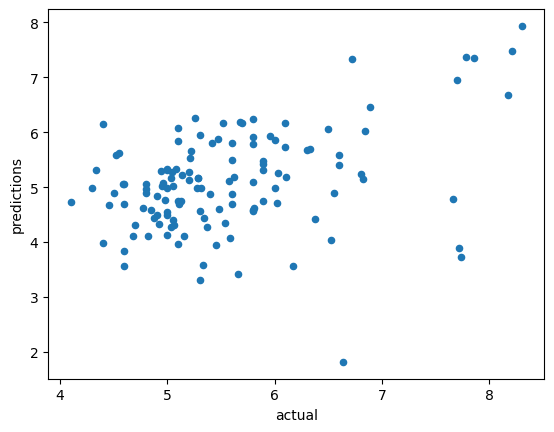

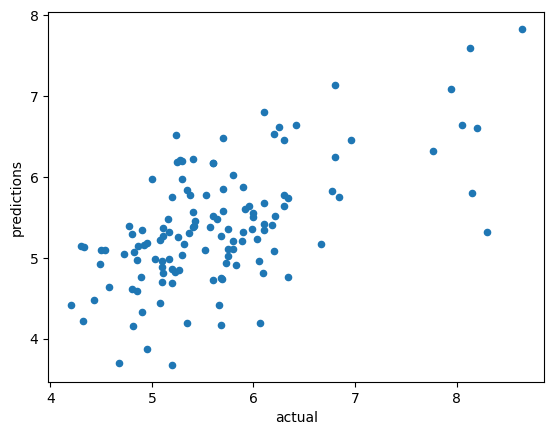

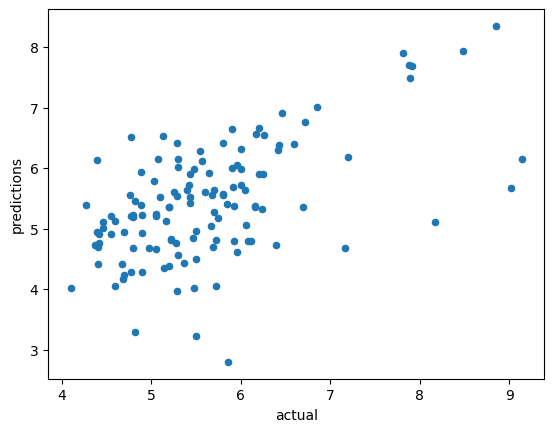

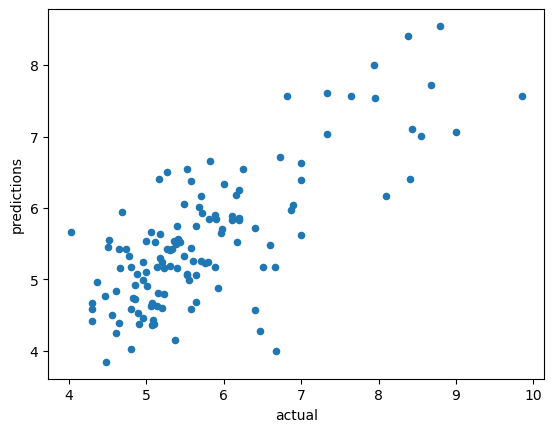

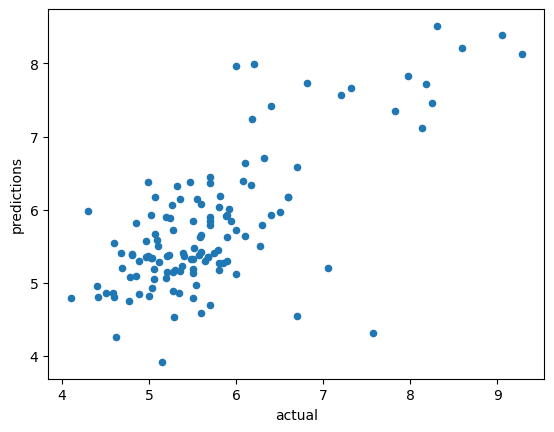

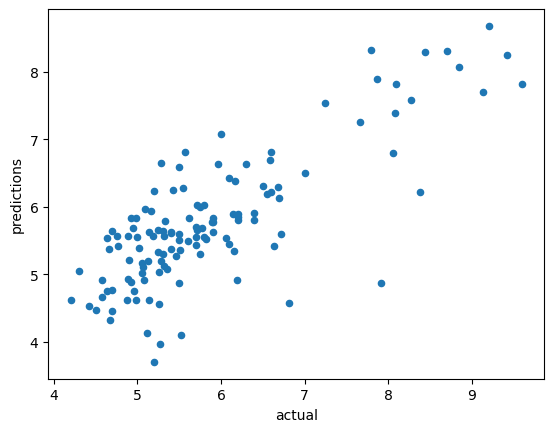

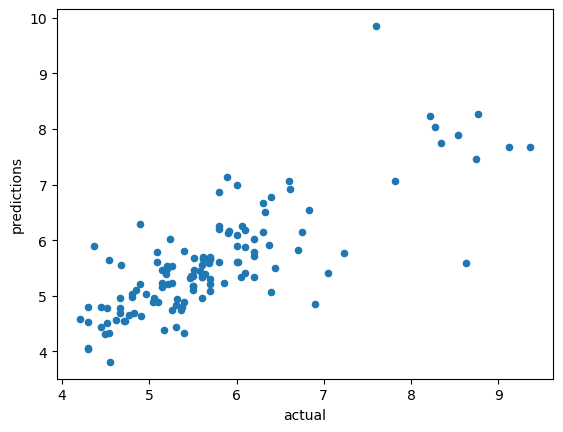

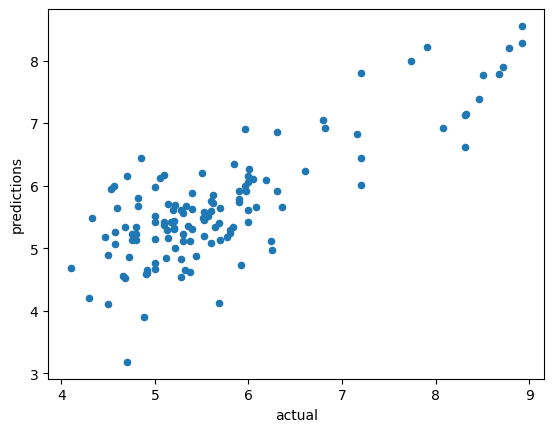

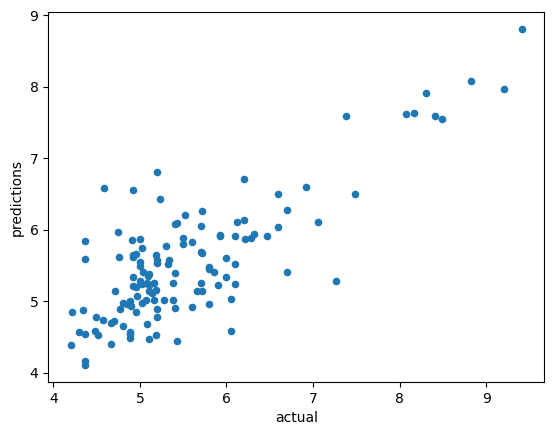

In [13]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df, false_disc, true_disc, true_ignore, false_ignore,rmse = perform_fcv(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [14]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(39, 3)
(29, 3)
(26, 3)
(32, 3)
(16, 3)
(22, 3)
(30, 3)
(21, 3)
(36, 3)


In [15]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(36, 3)
(22, 3)
(25, 3)
(18, 3)
(18, 3)
(11, 3)
(15, 3)
(16, 3)
(10, 3)


In [16]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(12, 3)
(9, 3)
(17, 3)
(14, 3)
(21, 3)
(16, 3)
(10, 3)
(24, 3)
(25, 3)


In [17]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(37, 3)
(62, 3)
(55, 3)
(60, 3)
(70, 3)
(75, 3)
(69, 3)
(62, 3)
(52, 3)


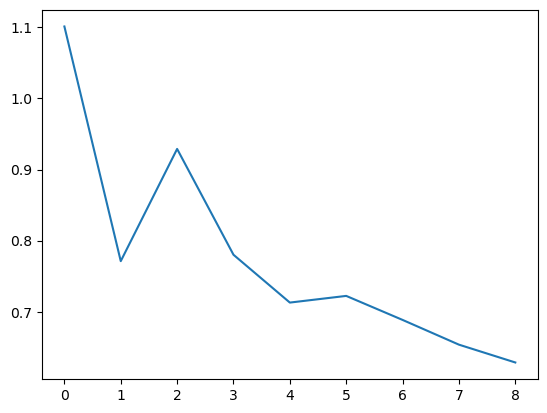

[1.1012985087835148, 0.7711709375307846, 0.929036905006035, 0.7801589362328697, 0.7128731694469238, 0.7222645521062687, 0.6884808327233057, 0.6536754252459002, 0.6286032157335859]


In [18]:
plt.plot(rmse)
plt.show()
print(rmse)

In [19]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

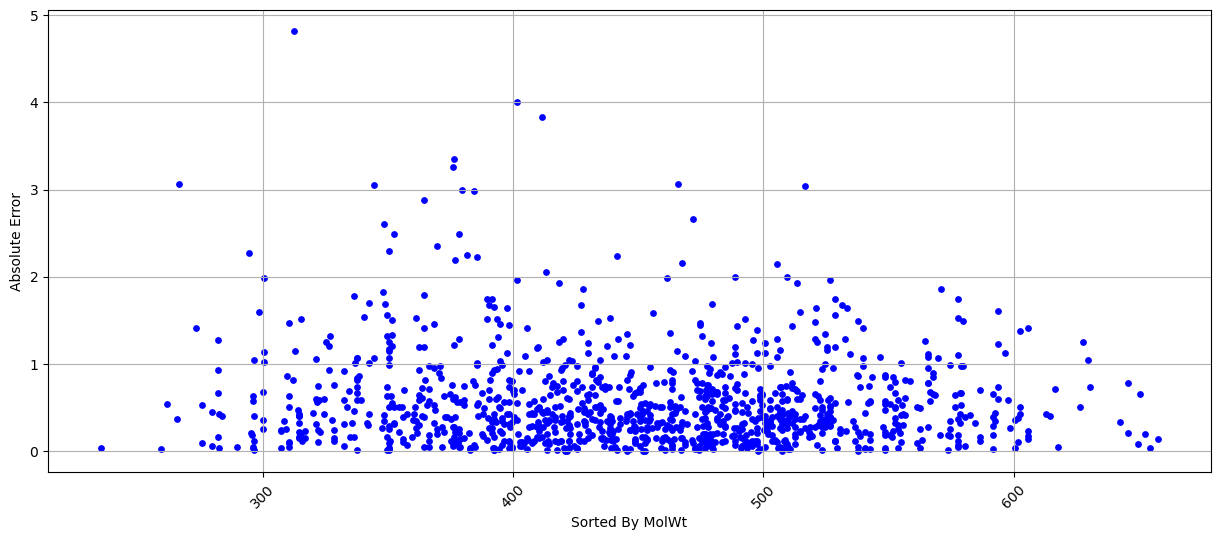

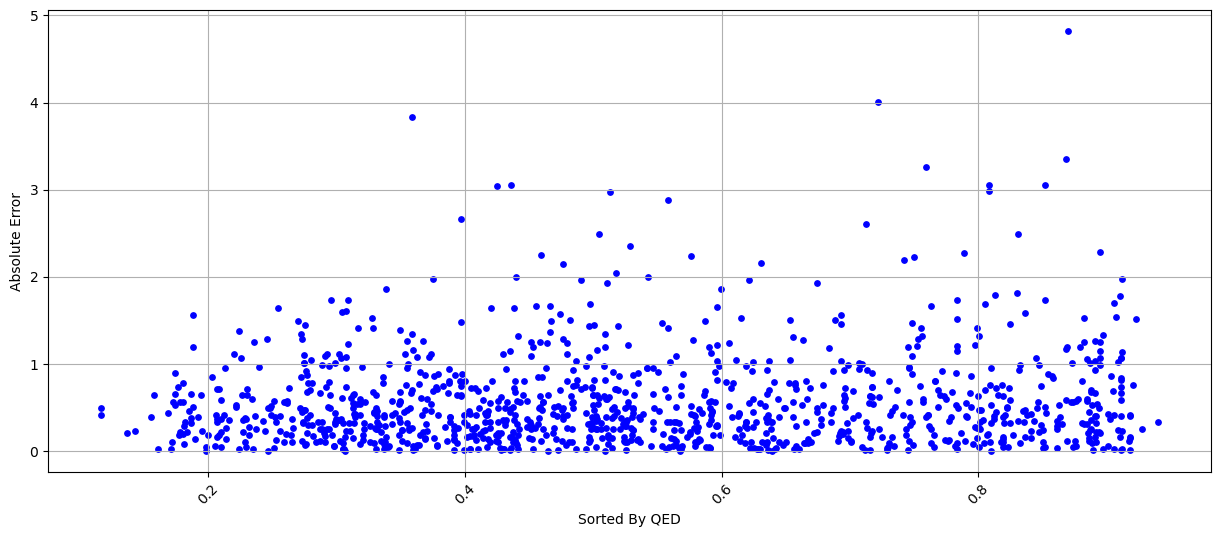

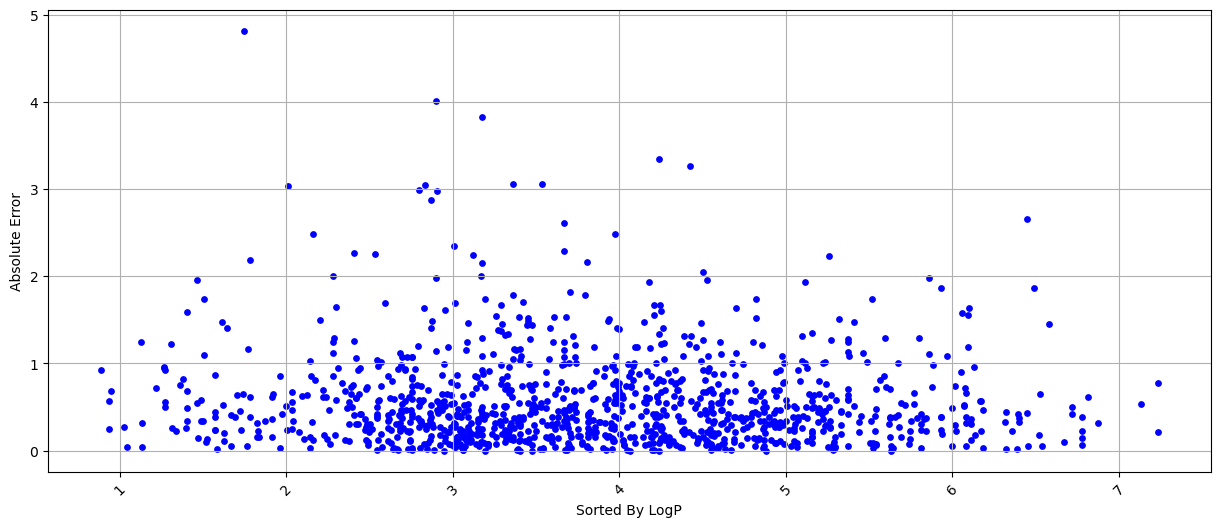

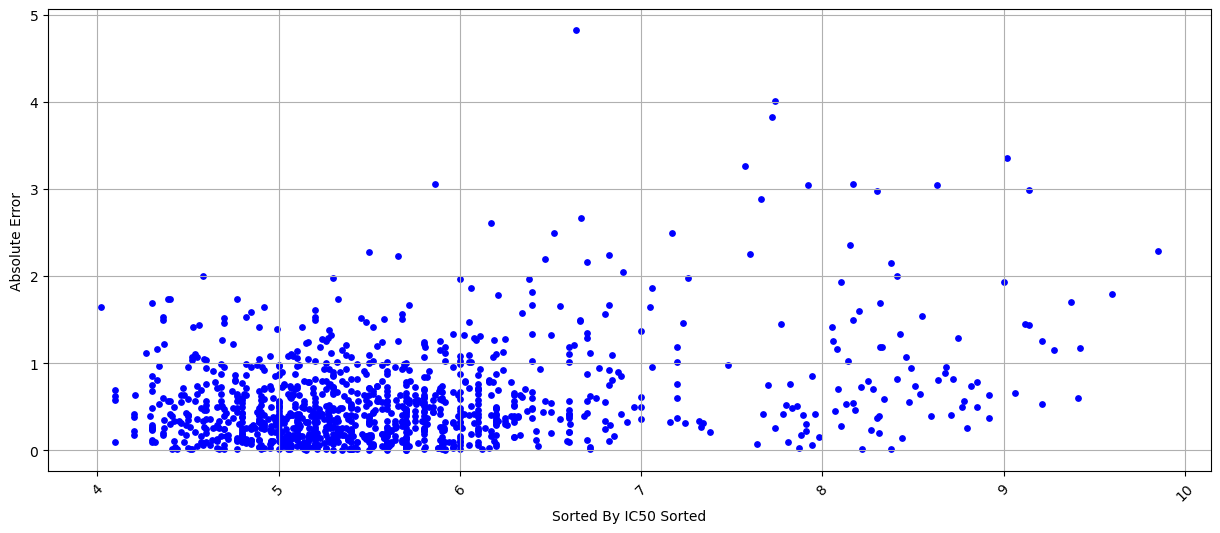

In [20]:
plot_graphs(df, results_df)

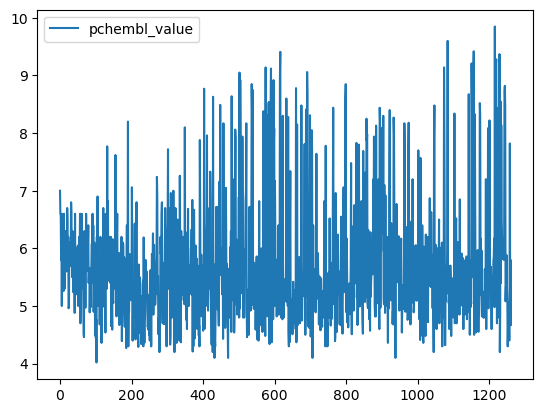

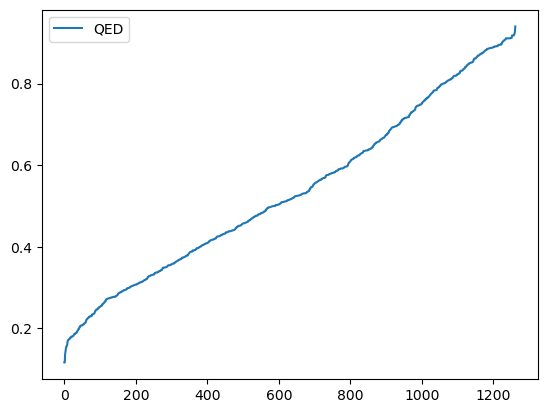

In [21]:
import random
df_copy=df.copy().sort_values(by="QED")#regular sort 
df_copy.plot(y="pchembl_value",use_index=False) #probabilities of each molecule being selected upon random selection without replacement
df_copy.plot(y="QED",use_index=False)

indices=df.nlargest(round(len(X)/10), ['QED']).index
X_test=X.copy()[indices]
y_test=y.copy()[indices]
smiles_test=smiles[indices]

X1=np.delete(X.copy(),indices,axis=0)
y1=np.delete(y.copy(),indices,axis=0)
smiles1=np.delete(smiles.copy(),indices,axis=0)


#X[df.nlargest(126, ['QED']).index].shape

In [22]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_fcv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        

        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = nn.MLPRegressor(hidden_layer_sizes=(min(25,round(np.sqrt(X_train.shape[0])),)), random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    # Optionally, save the results to a DataFrame
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
    })
    # Saving to CSV (optional)
    results_df.to_csv("unsorted_fcv_results_most_druglike_MLP.csv", index=False)

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=-0.015109203421211895, pvalue=0.8666464572604916)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=-0.25068708902115056, pvalue=0.004636393568665633)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=-0.25945163712771213, pvalue=0.003349229305662939)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.7470083133158916, pvalue=9.844980241051192e-24)
PearsonRResult(statistic=0.7406221891297822, pvalue=3.7108967209921036e-23)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.7531073209337038, pvalue=2.670181382266399e-24)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.7780974419312661, pvalue=8.325472252028981e-27)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.7871615600807604, pvalue=8.500788553545031e-28)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.8144980280114835, pvalue=4.190286297227954e-31)


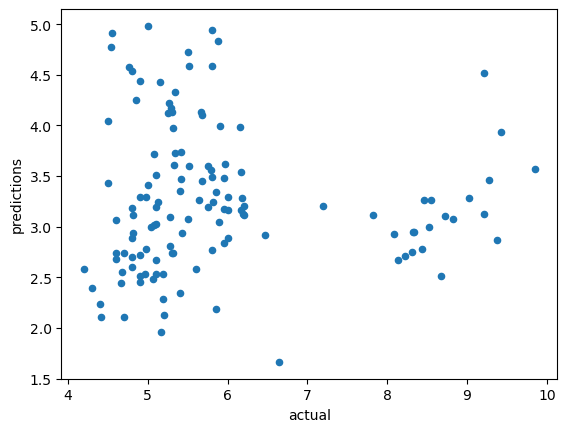

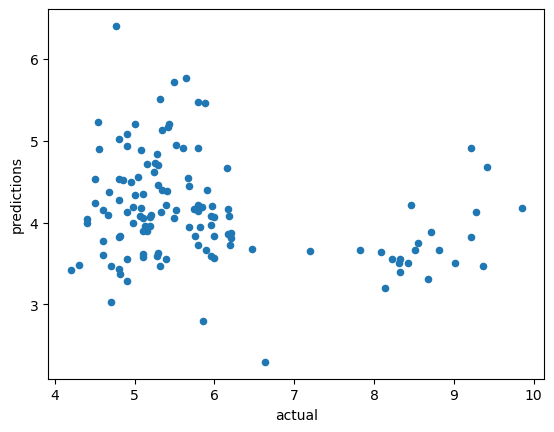

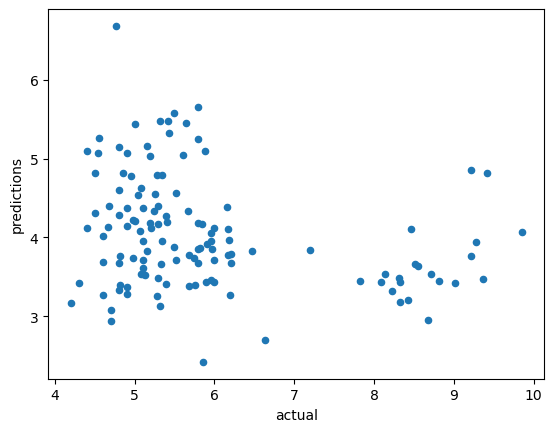

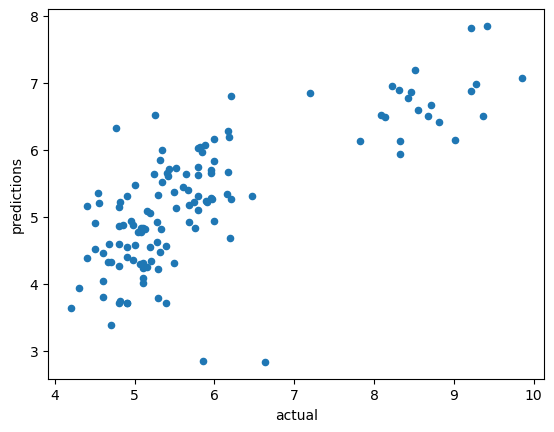

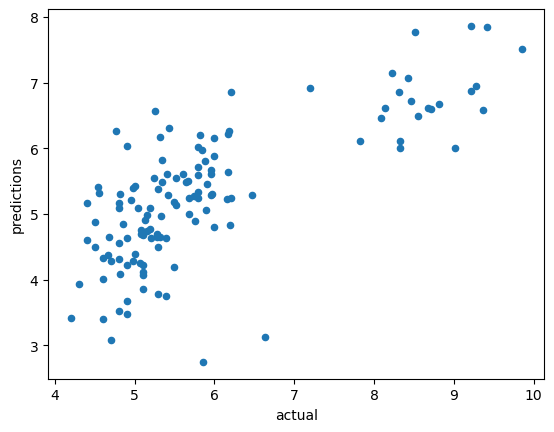

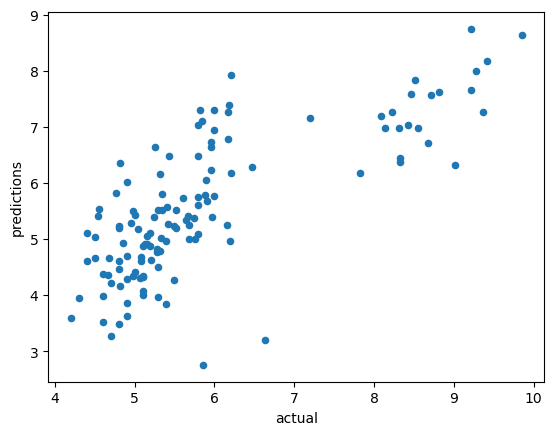

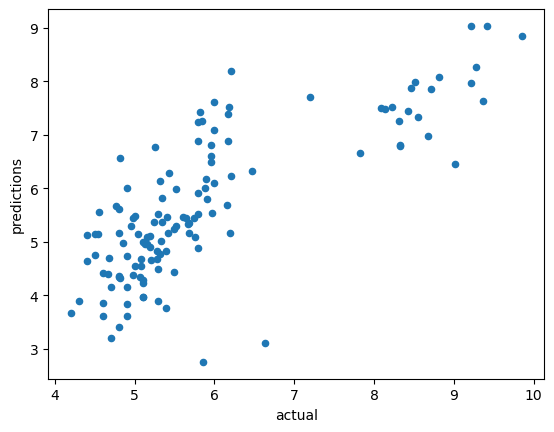

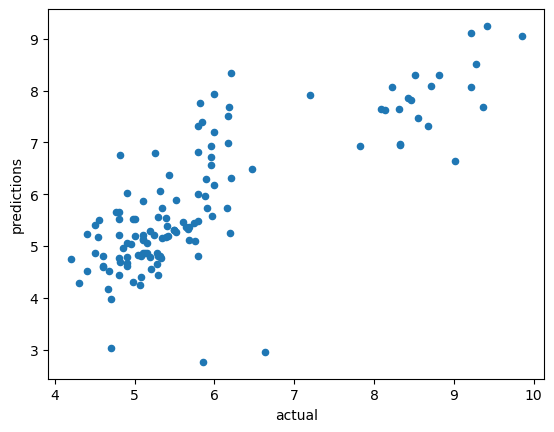

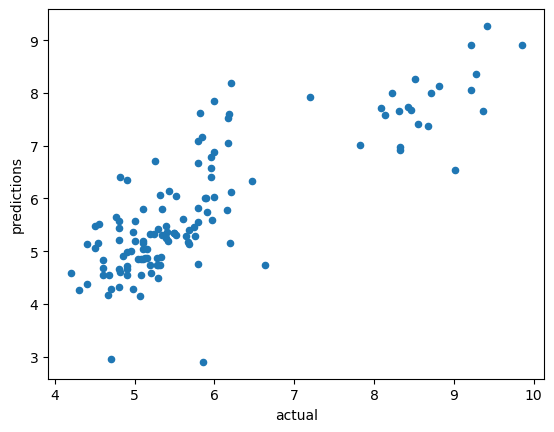

In [23]:


results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_fcv_on_most_druglike(X1, y1, smiles1, sort_by=None, additional_info=df["QED"])

In [24]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(48, 3)
(45, 3)
(45, 3)
(42, 3)
(40, 3)
(39, 3)
(40, 3)
(34, 3)
(36, 3)


In [25]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(77, 3)
(72, 3)
(70, 3)
(18, 3)
(18, 3)
(16, 3)
(16, 3)
(14, 3)
(13, 3)


In [26]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(0, 3)
(5, 3)
(7, 3)
(59, 3)
(59, 3)
(61, 3)
(61, 3)
(63, 3)
(64, 3)


In [27]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(0, 3)
(3, 3)
(3, 3)
(6, 3)
(8, 3)
(9, 3)
(8, 3)
(14, 3)
(12, 3)


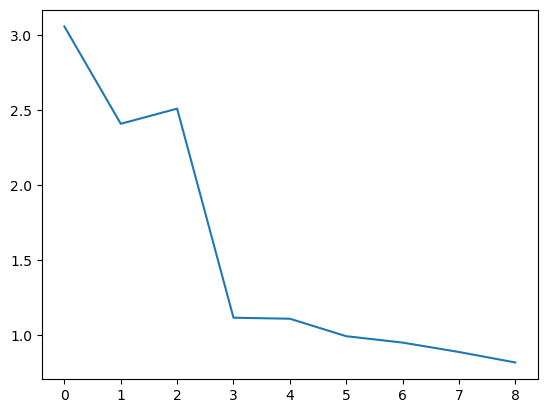

[3.055100287204269, 2.4066724843630203, 2.5075450485081103, 1.1142516066582917, 1.1075003604663716, 0.991048486342662, 0.9484672300522762, 0.88586200869001, 0.8159120708478317]


In [28]:
plt.plot(rmse)
plt.show()
print(rmse)